In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import deque
from datetime import datetime
from decimal import Decimal
from enum import Enum
from math import floor
import numpy as np
import pandas as pd
from random import randrange, seed
from os.path import join

import matplotlib.pyplot as plt
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/bhsu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#path = '/home/b3arjuden/crocket/sql_data/PRODUCTION40'

path = '/Users/bhsu/crypto/sql_data/PRODUCTION40'

file = 'BTC-ETH.csv'

In [3]:
file_path = join(path, file)

data = pd.read_csv(file_path, 
                   dtype={'time': str, 'buy_order': int, 'sell_order': int},
                   converters={'price': Decimal,
                               'wprice': Decimal,
                               'base_volume': Decimal,
                               'buy_volume': Decimal,
                               'sell_volume': Decimal})

In [4]:
GAMMA = 0.95
EPSILON = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995

In [19]:
def time_transform(df, n):
    
    df1 = pd.DataFrame()
    
    nrows = n * floor(df.shape[0] / n)
    df = df.iloc[:nrows, :]
    
    df1['time'] = df.loc[df.index[::n], 'time'].reset_index(drop=True)
    df1['wprice'] = ((df.loc[:, 'wprice'] * df.loc[:, 'base_volume']).groupby(df.index // n).sum() / 
                     df.loc[:, 'base_volume'].groupby(df.index // n).sum()).apply(lambda x: float(x.quantize(Decimal(10) ** -8)))
    df1['buy_volume'] = df.loc[:, 'buy_volume'].groupby(df.index // n).sum().apply(float)
    df1['sell_volume'] = df.loc[:, 'sell_volume'].groupby(df.index // n).sum().apply(float)
    df1['buy_order'] = df.loc[:, 'buy_order'].groupby(df.index // n).sum()
    df1['sell_order'] = df.loc[:, 'sell_order'].groupby(df.index // n).sum()
    
    return df1

def vectorize(array):
    
    return array.reshape(array.size, 1)

def unvectorize(vector, x, y):
    
    return vector.reshape(x, y)

In [6]:
class Agent:
    
    def __init__(self,
                 num_actions,
                 gamma=GAMMA, 
                 epsilon=EPSILON,
                 epsilon_min=EPSILON_MIN,
                 epsilon_decay=EPSILON_DECAY):
        
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.memory = deque(maxlen=2000)
        
        self._build_model()
        
    def _build_model(self):
        
        model = Sequential()
        model.add(Dense(units=30, input_dim=20, activation='relu'))
        model.add(Dense(units=3, activation='softmax'))
        
        # Optimizer: adam, RMSProp
        model.compile(optimizer='adam', loss='mse')
        
        self.model = model
    
    def remember(self, state, action, reward, next_state, done):
        
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        
        values = self.model.predict(state)
        
        return np.argmax(values[0])
    
    def replay(self, batch_size):
        
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * \
                       np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [7]:
class Environment:
    
    def __init__(self,
                 input_data,
                 steps=None):
        
        self.steps = steps
        self._load(input_data)
        
        self.episode = {}
        
    def _load(self, input_data):
        
        self.data = input_data
        
        self.shape = input_data.shape
        
        if self.steps is None or self.steps > self.shape[0]:
            self.steps = self.shape[0] - 1
    
    def _seed(self):
        
        seed()
    
    def _add_state(self):
        
        np.insert(self.data, self.shape[1], np.zeros(self.shape[1]), axis=1)
        
    def reset(self):
        
        self.episode['start'] = None
        self.data[:, -1] = 0  # Reset buy state
    
    def start(self):
        
        self._seed()
        self.episode['start'] = randrange(0, self.length - self.steps)
        self.episode['current_index'] = self.episode.get('start')
        self.episode['bought'] = False
        self.spisode['buy_price'] = 0
        
    def step(self, action):
        
        current_index = self.episode.get('current_index')
        state = self.data[current_index]
        next_state = self.data[current_index + 1]
        
        # Custom behaviors
        
        # Can only buy once
        if self.episode.get('bought'):
            if action == 1:
                action = 0
        else:
            if action == 1:
                self.episode['bought'] = True
                self.episode['buy_price'] = state[4]  # TODO: implement better way to keep track of current_price
                
        
        
        self.episode['current_index'] += 1
        
        return next_state, reward, done, 'tmp'
    
class Action(Enum):

    HOLD = 0
    BUY = 1
    SELL = 2

In [33]:
df = time_transform(data, 15)
array = df.iloc[:,1:].as_matrix()

In [11]:
df.head()

,time,wprice,buy_volume,sell_volume,buy_order,sell_order
0,2017-12-11 21:24:36.000000,0.032071,35.102470,47.005510,826,680
1,2017-12-11 21:39:36.000000,0.032045,31.962237,36.134730,515,520
2,2017-12-11 21:54:36.000000,0.031504,52.720665,44.804259,748,805
3,2017-12-11 22:09:36.000000,0.031444,37.816393,46.708993,662,574
4,2017-12-11 22:24:36.000000,0.031500,27.480918,13.696069,477,309


In [26]:
array.shape

(1347, 5)

In [32]:
array[0:5, :]

array([[  3.20706300e-02,   3.51024699e+01,   4.70055098e+01,
          8.26000000e+02,   0.00000000e+00],
       [  3.20452000e-02,   3.19622368e+01,   3.61347304e+01,
          5.15000000e+02,   0.00000000e+00],
       [  3.15044300e-02,   5.27206646e+01,   4.48042588e+01,
          7.48000000e+02,   0.00000000e+00],
       [  3.14440200e-02,   3.78163934e+01,   4.67089925e+01,
          6.62000000e+02,   0.00000000e+00],
       [  3.14998700e-02,   2.74809185e+01,   1.36960688e+01,
          4.77000000e+02,   0.00000000e+00]])

In [9]:
array[10]

array([  3.16471700e-02,   2.23109970e+01,   4.14240119e+01,
         5.02000000e+02,   6.92000000e+02])

In [31]:
seed(900)
print(randint(1,10))
print(randint(1,10))

seed(900)
print(randint(1,10))
print(randint(1,10))


10
4
10
4


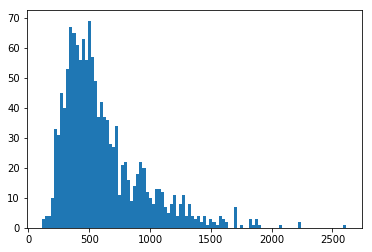

In [30]:
n, bins, patches = plt.hist(df['sell_order'], 100)

In [31]:
# Normalize data 
# TODO: change normalization if necessary
min_max_scaler = preprocessing.MinMaxScaler()
train = min_max_scaler.fit_transform(array)

In [71]:
a = Agent()

In [76]:
block = train[0:4, :].reshape(-1, 20)
a.model.predict(block)

array([[ 0.29833254,  0.39471743,  0.30695006]], dtype=float32)

In [11]:
# Training parameters
EPISODES = 1

In [12]:
## Main loop

agent = Agent(num_actions=3)
environment = Environment()

for index in range(EPISODES):
    
    print(index)

0


In [49]:
a = {'aa': 1}
a['bb'] = a.get('aa')

print(a)

a['bb'] += 1

print(a)

a['bb'] += 10

print(a)

{'aa': 1, 'bb': 1}
{'aa': 1, 'bb': 2}
{'aa': 1, 'bb': 12}
